# ViaRisk — Exploratory Data Analysis (EDA)

## Contexto
Este notebook analiza los **microdatos de accidentes de tráfico con víctimas (2024)** publicados por la **Dirección General de Tráfico (DGT)**.

El dataset contiene información detallada sobre accidentes ocurridos en España, incluyendo:
- Tipo de vehículo implicado
- Gravedad del accidente
- Tipo de vía
- Localización
- Variables temporales (fecha y hora)

## Objetivo
El objetivo de este análisis es **identificar patrones y factores de riesgo** asociados a los accidentes de tráfico, con especial atención a:
- Diferencias entre tipos de vehículos
- Relación entre tipo de vía y gravedad del accidente
- Patrones geográficos y temporales

## Preguntas de análisis
Este EDA busca responder, entre otras, a las siguientes preguntas:
1. ¿Qué tipos de vehículos están más implicados en accidentes con víctimas?
2. ¿Existen diferencias significativas en la gravedad de los accidentes según el tipo de vía?
3. ¿Cómo se distribuyen los accidentes a nivel geográfico (provincias)?
4. ¿Se observan patrones temporales claros (hora del día, día de la semana)?


# Fase Inicial

## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

## Cargar Excel

In [ ]:
file_path = "../data/raw/accidentes_victimas_2024.xlsx" 
diccionario_excel = "../data/raw/diccionario_codigos_2024.xlsx" 
accidentes = pd.read_excel(file_path)

accidentes.head()

,ID_ACCIDENTE,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,ZONA,ZONA_AGRUPADA,CARRETERA,KM,SENTIDO_1F,TITULARIDAD_VIA,TIPO_VIA,TIPO_ACCIDENTE,TOTAL_MU24H,TOTAL_HG24H,TOTAL_HL24H,TOTAL_VICTIMAS_24H,TOTAL_MU30DF,TOTAL_HG30DF,TOTAL_HL30DF,TOTAL_VICTIMAS_30DF,TOTAL_VEHICULOS,TOT_PEAT_MU24H,TOT_BICI_MU24H,TOT_CICLO_MU24H,TOT_MOTO_MU24H,TOT_TUR_MU24H,TOT_FURG_MU24H,TOT_CAM_MENOS3500_MU24H,TOT_CAM_MAS3500_MU24H,TOT_BUS_MU24H,TOT_OTRO_MU24H,TOT_SINESPECIF_MU24H,TOT_PEAT_MU30DF,TOT_BICI_MU30DF,TOT_CICLO_MU30DF,TOT_MOTO_MU30DF,TOT_TUR_MU30DF,TOT_FURG_MU30DF,TOT_CAM_MENOS3500_MU30DF,TOT_CAM_MAS3500_MU30DF,TOT_BUS_MU30DF,TOT_VMP_MU30DF,TOT_OTRO_MU30DF,TOT_SINESPECIF_MU30DF,NUDO,NUDO_INFO,CARRETERA_CRUCE,PRIORI_NORMA,PRIORI_AGENTE,PRIORI_SEMAFORO,PRIORI_VERT_STOP,PRIORI_VERT_CEDA,PRIORI_HORIZ_STOP,PRIORI_HORIZ_CEDA,PRIORI_MARCAS,PRIORI_PEA_NO_ELEV,PRIORI_PEA_ELEV,PRIORI_MARCA_CICLOS,PRIORI_CIRCUNSTANCIAL,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,1,2024,1,3,22,1,0,NaN,1,1,A-2622,33.0,1,3,6,18.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,1,6,1,NaN,NaN,1,998,1
1,2,2024,1,6,23,1,1036,NaN,1,1,A-625,369.0,1,3,5,16.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,6,4,NaN,NaN,1,998,3
2,3,2024,1,7,1,1,0,NaN,1,1,AP-1,82.0,1,2,2,12.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,6,3,NaN,NaN,1,998,1
3,4,2024,1,7,8,1,0,NaN,1,1,A-2522,32.0,1,3,6,13.0,0,0,2,2,0,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,1,3,NaN,NaN,1,998,3
4,5,2024,1,4,17,1,0,NaN,1,1,A-3600,19.0,1,3,14,15.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,1,2,NaN,NaN,1,998,1


## Inspección inicial de los datos

Esta celda muestra:
- Información general del dataframe
- Columnas con valores nulos
- Totales de víctimas por tipo de vehículo

In [3]:
# accidentes.info()  # Tipos de datos, columnas y nulos
print("\nNúmero de filas y columnas:", accidentes.shape)

# Recuento de nulos por columna
nulos = accidentes.isnull().sum()
print("\nNulos por columna:\n", nulos[nulos > 0])

# Sumar víctimas por tipo de vehículo en todo el dataset
columnas_vehiculos = [
    "TOT_PEAT_MU24H",
    "TOT_BICI_MU24H",
    "TOT_CICLO_MU24H",
    "TOT_MOTO_MU24H",
    "TOT_TUR_MU24H",
    "TOT_FURG_MU24H",
    "TOT_CAM_MENOS3500_MU24H",
    "TOT_CAM_MAS3500_MU24H",
    "TOT_BUS_MU24H",
    "TOT_OTRO_MU24H",
    "TOT_SINESPECIF_MU24H"
]

totales_vehiculos = accidentes[columnas_vehiculos].sum().sort_values(ascending=False)
print(totales_vehiculos)




Número de filas y columnas: (101996, 73)

Nulos por columna:
 ISLA                 97552
KM                   63182
TIPO_ACCIDENTE          35
NUDO                    33
NUDO_INFO            49034
CARRETERA_CRUCE      99318
CONDICION_NIEBLA     94514
CONDICION_VIENTO    101685
dtype: int64
TOT_TUR_MU24H              618
TOT_MOTO_MU24H             394
TOT_PEAT_MU24H             251
TOT_FURG_MU24H              84
TOT_BICI_MU24H              60
TOT_CAM_MAS3500_MU24H       37
TOT_CICLO_MU24H             29
TOT_OTRO_MU24H              24
TOT_CAM_MENOS3500_MU24H     12
TOT_BUS_MU24H                3
TOT_SINESPECIF_MU24H         2
dtype: int64


# Limpieza

## Limpieza de columnas y valores 

Eliminar estas columnas de análisis inicial ya que tienen más 90% nulos y aportan poco valor al principio


In [4]:
# Eliminar columnas con más de 90% nulos
threshold = 0.9
accidentes_limpios = accidentes.drop(columns=[col for col in accidentes.columns if accidentes[col].isnull().mean() > threshold])

In [5]:
columnas_vehiculos = [
    "TOT_PEAT_MU24H",
    "TOT_BICI_MU24H",
    "TOT_CICLO_MU24H",
    "TOT_MOTO_MU24H",
    "TOT_TUR_MU24H",
    "TOT_FURG_MU24H",
    "TOT_CAM_MENOS3500_MU24H",
    "TOT_CAM_MAS3500_MU24H",
    "TOT_BUS_MU24H",
    "TOT_OTRO_MU24H",
    "TOT_SINESPECIF_MU24H"
]

accidentes_limpios[columnas_vehiculos] = accidentes_limpios[columnas_vehiculos].fillna(0)


## Crear nueva columna derivada 
Diferencia entre el total de [MUERTOS_VEHICULOS] y [DIF_MUERTOS]

In [6]:
accidentes_limpios["MUERTOS_VEHICULOS"] = accidentes_limpios[columnas_vehiculos].sum(axis=1)

In [7]:
# Diferencia entre TOTAL_MU24H y suma por vehículo
accidentes_limpios["DIF_MUERTOS"] = accidentes_limpios["TOTAL_MU24H"] - accidentes_limpios["MUERTOS_VEHICULOS"]
print(accidentes_limpios["DIF_MUERTOS"].describe())


count    101996.000000
mean          0.000078
std           0.008856
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: DIF_MUERTOS, dtype: float64


## Unificar diccionario

In [36]:
# Cargar la hoja de provincias con la fila correcta como header
dic_prov = pd.read_excel(diccionario_excel, sheet_name="COD_PROVINCIA", header=1)  
dic_prov.columns = dic_prov.columns.str.strip()  # elimina espacios

# Crear el diccionario de mapeo
prov_dict = dict(zip(dic_prov["Valor"], dic_prov["Etiqueta"]))

# Mapear sobre el dataset
accidentes_limpios["PROVINCIA"] = accidentes_limpios["COD_PROVINCIA"].map(prov_dict)

# Tipo de vía
dic_via = pd.read_excel(diccionario_excel, sheet_name="TIPO_VIA", header=1)
dic_via.columns = dic_via.columns.str.strip()
via_dict = dict(zip(dic_via["Valor"], dic_via["Etiqueta"]))
accidentes_limpios["TIPO_VIA_NOMBRE"] = accidentes_limpios["TIPO_VIA"].map(via_dict)

# Día de la semana
dic_dia = pd.read_excel(diccionario_excel, sheet_name="DIA_SEMANA", header=1)
dic_dia.columns = dic_dia.columns.str.strip()
dia_dict = dict(zip(dic_dia["Valor"], dic_dia["Etiqueta"]))
accidentes_limpios["DIA_SEMANA_NOMBRE"] = accidentes_limpios["DIA_SEMANA"].map(dia_dict)

# Tipo de accidente
dic_acc = pd.read_excel(diccionario_excel, sheet_name="TIPO_ACCIDENTE", header=1)
dic_acc.columns = dic_acc.columns.str.strip()
acc_dict = dict(zip(dic_acc["Valor"], dic_acc["Etiqueta"]))
accidentes_limpios["TIPO_ACCIDENTE_NOMBRE"] = accidentes_limpios["TIPO_ACCIDENTE"].map(acc_dict)


# Análisis básico

## Víctimas por provincia

In [16]:
# Agrupar por provincia y sumar víctimas
gravedad_prov = accidentes_limpios.groupby("PROVINCIA")[["TOTAL_MU24H","TOTAL_HG24H","TOTAL_HL24H"]].sum()
gravedad_prov_sorted = gravedad_prov.sort_values("TOTAL_MU24H", ascending=False)

gravedad_prov_sorted.head(10)  # top 10 provincias más graves


,TOTAL_MU24H,TOTAL_HG24H,TOTAL_HL24H
PROVINCIA,,,
Madrid,104,994,17052
Barcelona,89,1259,21921
Murcia,68,334,5001
Sevilla,65,369,6370
Valencia/València,60,483,6556
Málaga,59,324,6660
Alicante/Alacant,58,414,4449
Granada,54,120,1677
"Balears, Illes",49,320,3463


## Gravedad por tipo de vía

In [17]:
# Agrupar por tipo de vía legible y sumar víctimas
gravedad_via = accidentes_limpios.groupby("TIPO_VIA_NOMBRE")[["TOTAL_MU24H","TOTAL_HG24H","TOTAL_HL24H"]].sum()

# Ordenar por muertos
gravedad_via_sorted = gravedad_via.sort_values("TOTAL_MU24H", ascending=False)

gravedad_via_sorted

,TOTAL_MU24H,TOTAL_HG24H,TOTAL_HL24H
TIPO_VIA_NOMBRE,,,
Carretera Convencional de calzada única,731,3113,26031
Calle,258,3742,56126
Autovía,253,754,12199
Otro,90,1375,20026
Autopista libre,61,307,5238
Camino vecinal,51,213,1240
Carretera Convencional de doble calzada,43,161,2298
Autopista de peaje,18,44,652
Vía de servicio,9,44,454


## Accidentes por día de la semana

In [18]:
gravedad_dia = accidentes_limpios.groupby("DIA_SEMANA_NOMBRE")[["TOTAL_MU24H","TOTAL_HG24H","TOTAL_HL24H"]].sum()
gravedad_dia_sorted = gravedad_dia.sort_values("TOTAL_MU24H", ascending=False)

gravedad_dia_sorted

,TOTAL_MU24H,TOTAL_HG24H,TOTAL_HL24H
DIA_SEMANA_NOMBRE,,,
SÁBADO,287,1549,17335
DOMINGO,258,1500,14908
VIERNES,225,1481,19918
LUNES,201,1363,18501
JUEVES,199,1312,18301
MIÉRCOLES,179,1298,17928
MARTES,173,1302,18210


## Análisis gráfico

In [37]:
victimas_mes = accidentes_limpios.groupby("MES")[["TOTAL_VICTIMAS_24H"]].sum().reset_index()
fig_mes = px.bar(victimas_mes, x="MES", y="TOTAL_VICTIMAS_24H",
                 width=800,
                 title="Víctimas por mes",
                 labels={"MES":"Mes", "TOTAL_VICTIMAS_24H":"Número de víctimas"})

# Víctimas por día de la semana (legible)
victimas_dia = accidentes_limpios.groupby("DIA_SEMANA_NOMBRE")[["TOTAL_VICTIMAS_24H"]].sum().reset_index()
fig_dia = px.bar(victimas_dia, x="DIA_SEMANA_NOMBRE", y="TOTAL_VICTIMAS_24H",
                 width=800,
                 title="Víctimas por día de la semana",
                 labels={"DIA_SEMANA_NOMBRE":"Día de la semana", "TOTAL_VICTIMAS_24H":"Número de víctimas"})


# Víctimas por hora del día
victimas_hora = accidentes_limpios.groupby("HORA")[["TOTAL_VICTIMAS_24H"]].sum().reset_index()
fig_hora = px.bar(victimas_hora, x="HORA", y="TOTAL_VICTIMAS_24H",
                  width=800,
                  title="Víctimas por hora del día",
                  labels={"HORA":"Hora", "TOTAL_VICTIMAS_24H":"Número de víctimas"})

fig_mes.show()
fig_dia.show()
fig_hora.show()



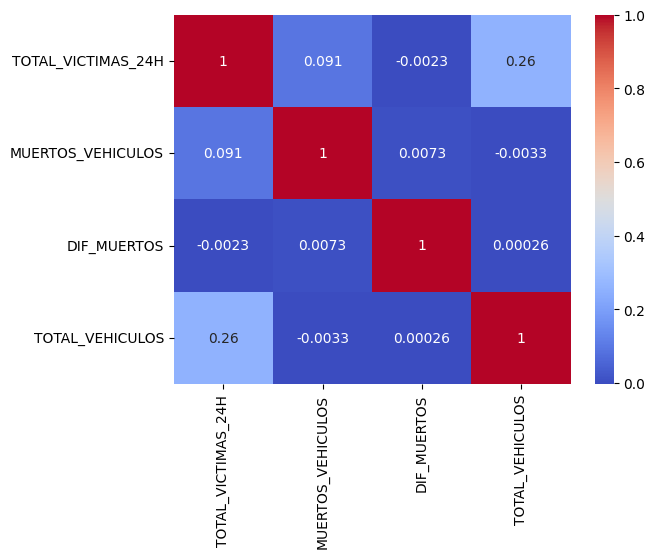

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación simple entre columnas de interés
cols = ["TOTAL_VICTIMAS_24H", "MUERTOS_VEHICULOS", "DIF_MUERTOS", "TOTAL_VEHICULOS"]
sns.heatmap(accidentes_limpios[cols].corr(), annot=True, cmap="coolwarm")
plt.show()


In [39]:
accidentes_limpios.head()

,ID_ACCIDENTE,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,CARRETERA,KM,SENTIDO_1F,TITULARIDAD_VIA,TIPO_VIA,TIPO_ACCIDENTE,TOTAL_MU24H,TOTAL_HG24H,TOTAL_HL24H,TOTAL_VICTIMAS_24H,TOTAL_MU30DF,TOTAL_HG30DF,TOTAL_HL30DF,TOTAL_VICTIMAS_30DF,TOTAL_VEHICULOS,TOT_PEAT_MU24H,TOT_BICI_MU24H,TOT_CICLO_MU24H,TOT_MOTO_MU24H,TOT_TUR_MU24H,TOT_FURG_MU24H,TOT_CAM_MENOS3500_MU24H,TOT_CAM_MAS3500_MU24H,TOT_BUS_MU24H,TOT_OTRO_MU24H,TOT_SINESPECIF_MU24H,TOT_PEAT_MU30DF,TOT_BICI_MU30DF,TOT_CICLO_MU30DF,TOT_MOTO_MU30DF,TOT_TUR_MU30DF,TOT_FURG_MU30DF,TOT_CAM_MENOS3500_MU30DF,TOT_CAM_MAS3500_MU30DF,TOT_BUS_MU30DF,TOT_VMP_MU30DF,TOT_OTRO_MU30DF,TOT_SINESPECIF_MU30DF,NUDO,NUDO_INFO,PRIORI_NORMA,PRIORI_AGENTE,PRIORI_SEMAFORO,PRIORI_VERT_STOP,PRIORI_VERT_CEDA,PRIORI_HORIZ_STOP,PRIORI_HORIZ_CEDA,PRIORI_MARCAS,PRIORI_PEA_NO_ELEV,PRIORI_PEA_ELEV,PRIORI_MARCA_CICLOS,PRIORI_CIRCUNSTANCIAL,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA,MUERTOS_VEHICULOS,DIF_MUERTOS,PROVINCIA,TIPO_VIA_NOMBRE,DIA_SEMANA_NOMBRE,TIPO_ACCIDENTE_NOMBRE
0,1,2024,1,3,22,1,0,1,1,A-2622,33.0,1,3,6,18.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,1,6,1,1,998,1,0,0,Araba/Álava,Carretera Convencional de calzada única,MIÉRCOLES,Salida de la vía por la derecha con vuelco ...
1,2,2024,1,6,23,1,1036,1,1,A-625,369.0,1,3,5,16.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,6,4,1,998,3,0,0,Araba/Álava,Carretera Convencional de doble calzada,SÁBADO,Salida de la vía por la derecha con colisión ...
2,3,2024,1,7,1,1,0,1,1,AP-1,82.0,1,2,2,12.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,6,3,1,998,1,0,0,Araba/Álava,Autopista libre,DOMINGO,Salida de la vía por la izquierda con colisión...
3,4,2024,1,7,8,1,0,1,1,A-2522,32.0,1,3,6,13.0,0,0,2,2,0,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,1,3,1,998,3,0,0,Araba/Álava,Carretera Convencional de calzada única,DOMINGO,Salida de la vía por la izquierda con despeñam...
4,5,2024,1,4,17,1,0,1,1,A-3600,19.0,1,3,14,15.0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN,999,999,999,999,999,999,999,999,999,999,999,999,999,1,3,1,2,1,998,1,0,0,Araba/Álava,Otro,JUEVES,"Salida de la vía por la izquierda, otro tipo ..."


In [45]:
# --- Cargar diccionario de códigos ---
diccionario_excel = pd.ExcelFile("../data/raw/diccionario_codigos_2024.xlsx")

# Función para mapear columnas usando sheet_name
def mapear_codigo(col_name, sheet_name, df, new_col_name=None):
    df_dic = pd.read_excel(diccionario_excel, sheet_name=sheet_name, header=1)
    df_dic.columns = df_dic.columns.str.strip()
    dic = dict(zip(df_dic["Valor"], df_dic["Etiqueta"]))
    if new_col_name is None:
        new_col_name = f"{col_name}_NOMBRE"
    df[new_col_name] = df[col_name].map(dic).fillna("Sin especificar")

# --- Mapear columnas principales ---
mapear_codigo("COD_PROVINCIA", "COD_PROVINCIA", accidentes_limpios, "PROVINCIA")
mapear_codigo("TIPO_VIA", "TIPO_VIA", accidentes_limpios, "TIPO_VIA_NOMBRE")
mapear_codigo("DIA_SEMANA", "DIA_SEMANA", accidentes_limpios, "DIA_SEMANA_NOMBRE")
mapear_codigo("TIPO_ACCIDENTE", "TIPO_ACCIDENTE", accidentes_limpios, "TIPO_ACCIDENTE_NOMBRE")

# --- Mapear resto de columnas del diccionario ---
columnas_a_mapear = [
    ("NUDO", "NUDO"),
    ("NUDO_INFO", "NUDO_INFO"),
    ("PRIORI_NORMA", "PRIORI_NORMA"),
    ("PRIORI_AGENTE", "PRIORI_AGENTE"),
    ("PRIORI_SEMAFORO", "PRIORI_SEMAFORO"),
    ("PRIORI_VERT_STOP", "PRIORI_VERT_STOP"),
    ("PRIORI_VERT_CEDA", "PRIORI_VERT_CEDA"),
    ("PRIORI_HORIZ_STOP", "PRIORI_HORIZ_STOP"),
    ("PRIORI_HORIZ_CEDA", "PRIORI_HORIZ_CEDA"),
    ("PRIORI_MARCAS", "PRIORI_MARCAS"),
    ("PRIORI_PEA_NO_ELEV", "PRIORI_PEA_NO_ELEV"),
    ("PRIORI_PEA_ELEV", "PRIORI_PEA_ELEV"),
    ("PRIORI_MARCA_CICLOS", "PRIORI_MARCA_CICLOS"),
    ("PRIORI_CIRCUNSTANCIAL", "PRIORI_CIRCUNSTANCIAL"),
    ("PRIORI_OTRA", "PRIORI_OTRA"),
    ("ACERA", "ACERA"),
    ("TRAZADO_PLANTA", "TRAZADO_PLANTA")
]

for col, sheet in columnas_a_mapear:
    try:
        mapear_codigo(col, sheet, accidentes_limpios)
    except Exception as e:
        print(f"No se pudo mapear {col}: {e}")

# --- Guardar CSV limpio para siguiente notebook ---
cols_finales = [
    "ID_ACCIDENTE", "ANYO", "MES", "DIA_SEMANA", "DIA_SEMANA_NOMBRE", "HORA",
    "PROVINCIA", "COD_MUNICIPIO", "ZONA", "ZONA_AGRUPADA", "CARRETERA", "KM",
    "SENTIDO_1F", "TITULARIDAD_VIA", "TIPO_VIA", "TIPO_VIA_NOMBRE",
    "TIPO_ACCIDENTE", "TIPO_ACCIDENTE_NOMBRE",
    "TOTAL_MU24H", "TOTAL_HG24H", "TOTAL_HL24H", "TOTAL_VICTIMAS_24H",
    "TOTAL_VEHICULOS", "MUERTOS_VEHICULOS", "DIF_MUERTOS"
] + [f"{col}_NOMBRE" for col, _ in columnas_a_mapear]

accidentes_limpios[cols_finales].to_csv(
    "../data/processed/accidentes_limpios_2024.csv",
    index=False,
    sep=';',             
    encoding='utf-8-sig' 
)
print("CSV limpio creado con columnas mapeadas y nombres legibles.")



CSV limpio creado con columnas mapeadas y nombres legibles.
